In [1]:
import pandas as pd
import numpy as np

from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, balanced_accuracy_score, roc_auc_score
from keras_preprocessing.text import Tokenizer

import matplotlib.pyplot as plt

In [2]:
import os
import tensorflow as tf
import random
# fix the random seed for tensorflow models
os.environ['TF_DETERMINISTIC_OPS'] = '1' 
SEED = 39
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# set to use flexible GPU resources  
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [3]:
print(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}.")

Num GPUs Available: 1.


## Load data

In [ ]:
text_data = pd.read_csv('./texts.csv')

text_data.head()

In [5]:
# X, y = text_data['text'], text_data['mortality']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=39, stratify=y)

In [6]:
with open('./ids.npy', 'rb') as f:
    join_train_hadm_idx = np.load(f)
    join_val_hadm_idx = np.load(f)
    join_test_hadm_idx = np.load(f)

In [7]:
train_data = text_data[text_data['hadm_id'].isin(set(join_train_hadm_idx))]
val_data = text_data[text_data['hadm_id'].isin(set(join_val_hadm_idx))]
test_data = text_data[text_data['hadm_id'].isin(set(join_test_hadm_idx))]

X_train, y_train = train_data['text'],  train_data['mortality']
X_val, y_val = val_data['text'],  val_data['mortality']
X_test, y_test = test_data['text'],  test_data['mortality']

In [8]:
NUM_WORDS = 3000

# Tokenize the train text
train_text = X_train.to_numpy()

tokenizer = Tokenizer(
    num_words=NUM_WORDS, 
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', 
    lower=True,
    split=" ",
    char_level=False,
    oov_token='<unk>',
    document_count=0
)

tokenizer.fit_on_texts(train_text)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [9]:
MAX_LEN = 1000

X_train_seqs = tokenizer.texts_to_sequences(train_text)
X_train_seqs = keras.preprocessing.sequence.pad_sequences(X_train_seqs, maxlen=MAX_LEN, padding='post')
y_train_labels = y_train.to_numpy().flatten()

X_val_text = X_val.to_numpy()
X_val_seqs = tokenizer.texts_to_sequences(X_val_text)
X_val_seqs = keras.preprocessing.sequence.pad_sequences(X_val_seqs, maxlen=MAX_LEN, padding='post')
y_val_labels = y_val.to_numpy().flatten()

X_test_text = X_test.to_numpy()
X_test_seqs = tokenizer.texts_to_sequences(X_test_text)
X_test_seqs = keras.preprocessing.sequence.pad_sequences(X_test_seqs, maxlen=MAX_LEN, padding='post')
y_test_labels = y_test.to_numpy().flatten()

In [10]:
X_train_seqs

array([[ 147,  807,  976, ...,  149,    1,    2],
       [  14, 1403,   82, ...,  108,  764,  767],
       [   7,  151, 1162, ...,   63,  712,  332],
       ...,
       [ 113,   74, 1416, ...,    0,    0,    0],
       [ 113,   74,  831, ...,    0,    0,    0],
       [ 274,  508, 1523, ...,    0,    0,    0]], dtype=int32)

In [11]:
X_train_seqs.shape

# (30455, 606752) without preprocessing/limiting and truncating

(1529, 1000)

In [12]:
print(pd.value_counts(y_train))
print(pd.value_counts(y_val))
print(pd.value_counts(y_test))

0    1256
1     273
Name: mortality, dtype: int64
0    177
1     42
Name: mortality, dtype: int64
0    369
1     68
Name: mortality, dtype: int64


## Compensate for imbalanced data

In [13]:
neg, pos = np.bincount(y_train_labels)
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(total, pos, 100 * pos / total))

Examples:
    Total: 1529
    Positive: 273 (17.85% of total)



In [14]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.61
Weight for class 1: 2.80


In [15]:
initial_bias = np.log([pos/neg])
initial_bias

array([-1.52621555])

## LSTM model

### simple LSTM

In [16]:
# Method: For plotting the accuracy/loss of keras models
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [17]:
def SimpleClassifier(input_size, initial_bias):
    # Define the model structure - only LSTM layers
    inputs = keras.Input(input_size,)
    x = keras.layers.Embedding(input_dim=NUM_WORDS, output_dim=64, input_length=input_size)(inputs)
    x = keras.layers.LSTM(32, activation='tanh')(x)
    outputs = keras.layers.Dense(1, activation='sigmoid', 
                                 bias_initializer=keras.initializers.Constant(initial_bias))(x)

    classifier = keras.Model(inputs, outputs)
    
    optimizer = keras.optimizers.RMSprop(learning_rate=0.001)
    classifier.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return classifier

In [18]:
classifier1 = SimpleClassifier(input_size=MAX_LEN, initial_bias=initial_bias)

classifier1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1000)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 1000, 64)          192000    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                12416     
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 204,449
Trainable params: 204,449
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Define the early stopping criteria
early_stopping_accuracy = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Train the model
# reset_seeds()
classifier_history1 = classifier1.fit(X_train_seqs, 
          y_train_labels, 
          epochs=50,
          batch_size=128,
          shuffle=True, 
          verbose=True, 
          validation_data=(X_test_seqs, y_test_labels),
          callbacks=[early_stopping_accuracy],
          class_weight=class_weight)

Epoch 1/50
12/12 [==============================] - 3s 102ms/step - loss: 0.8353 - accuracy: 0.7945 - val_loss: 0.8328 - val_accuracy: 0.1579
Epoch 2/50
12/12 [==============================] - 1s 56ms/step - loss: 0.6424 - accuracy: 0.5712 - val_loss: 0.5123 - val_accuracy: 0.8146
Epoch 3/50
12/12 [==============================] - 1s 55ms/step - loss: 0.5874 - accuracy: 0.7545 - val_loss: 0.4524 - val_accuracy: 0.8352
Epoch 4/50
12/12 [==============================] - 1s 57ms/step - loss: 0.5197 - accuracy: 0.8475 - val_loss: 0.5695 - val_accuracy: 0.7277
Epoch 5/50
12/12 [==============================] - 1s 56ms/step - loss: 0.4280 - accuracy: 0.8451 - val_loss: 0.5735 - val_accuracy: 0.7506
Epoch 6/50
12/12 [==============================] - 1s 56ms/step - loss: 0.3912 - accuracy: 0.8895 - val_loss: 0.5599 - val_accuracy: 0.7735
Epoch 7/50
12/12 [==============================] - 1s 56ms/step - loss: 0.3608 - accuracy: 0.8945 - val_loss: 0.8534 - val_accuracy: 0.5172
Epoch 8/50
1

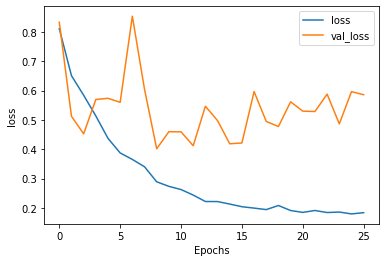

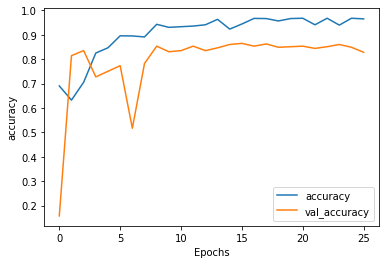

In [20]:
plot_graphs(classifier_history1, "loss")
plot_graphs(classifier_history1, "accuracy")

In [21]:
y_pred = classifier1.predict(X_test_seqs)
y_pred_classes = np.array([1 if pred > 0.5 else 0 for pred in y_pred])

# classification report
acc = accuracy_score(y_true=y_test_labels, y_pred=y_pred_classes)
print(acc)

bal_acc = balanced_accuracy_score(y_true=y_test, y_pred=y_pred_classes)
print(bal_acc)

auc = roc_auc_score(y_true=y_test_labels, y_score=y_pred)
print(auc)

confusion_matrix_df = pd.DataFrame(
        confusion_matrix(y_true=y_test_labels, y_pred=y_pred_classes, labels=[1, 0]),
        index=['True:pos', 'True:neg'], 
        columns=['Pred:pos', 'Pred:neg']
    )
print(confusion_matrix_df)

print(classification_report(y_true=y_test_labels, y_pred=y_pred_classes))

0.8649885583524027
0.6021640363462458
0.6479355970030287
          Pred:pos  Pred:neg
True:pos        15        53
True:neg         6       363
              precision    recall  f1-score   support

           0       0.87      0.98      0.92       369
           1       0.71      0.22      0.34        68

    accuracy                           0.86       437
   macro avg       0.79      0.60      0.63       437
weighted avg       0.85      0.86      0.83       437



### Adding regularization

In [22]:
def RegularizedClassifier(input_size, initial_bias):
    # Define the model structure - only LSTM layers
    inputs = keras.Input(input_size,)
    x = keras.layers.Embedding(input_dim=NUM_WORDS, output_dim=64, input_length=input_size)(inputs)
    x = keras.layers.LSTM(32, activation='tanh', kernel_regularizer=keras.regularizers.L1L2(l1=0.01, l2=0.01))(x)
    outputs = keras.layers.Dense(1, activation='sigmoid', 
                                 bias_initializer=keras.initializers.Constant(initial_bias))(x)

    classifier = keras.Model(inputs, outputs)
    
    optimizer = keras.optimizers.RMSprop(learning_rate=0.001)
    classifier.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return classifier

In [23]:
classifier2 = RegularizedClassifier(input_size=MAX_LEN, initial_bias=initial_bias)

classifier2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1000)]            0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 64)          192000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 204,449
Trainable params: 204,449
Non-trainable params: 0
_________________________________________________________________


In [24]:
# Train the model
# reset_seeds()
classifier_history2 = classifier2.fit(X_train_seqs, 
          y_train_labels, 
          epochs=50,
          batch_size=128,
          shuffle=True, 
          verbose=True, 
          validation_data=(X_test_seqs, y_test_labels),
          callbacks=[early_stopping_accuracy],
          class_weight=class_weight)

Epoch 1/50
12/12 [==============================] - 2s 80ms/step - loss: 8.4010 - accuracy: 0.8196 - val_loss: 7.1581 - val_accuracy: 0.1556
Epoch 2/50
12/12 [==============================] - 1s 56ms/step - loss: 6.7565 - accuracy: 0.5712 - val_loss: 5.9307 - val_accuracy: 0.8261
Epoch 3/50
12/12 [==============================] - 1s 56ms/step - loss: 5.7561 - accuracy: 0.6817 - val_loss: 4.9085 - val_accuracy: 0.8444
Epoch 4/50
12/12 [==============================] - 1s 57ms/step - loss: 4.9034 - accuracy: 0.7463 - val_loss: 4.2974 - val_accuracy: 0.6270
Epoch 5/50
12/12 [==============================] - 1s 56ms/step - loss: 4.1038 - accuracy: 0.7368 - val_loss: 3.6596 - val_accuracy: 0.6178
Epoch 6/50
12/12 [==============================] - 1s 55ms/step - loss: 3.4157 - accuracy: 0.7368 - val_loss: 2.9500 - val_accuracy: 0.7254
Epoch 7/50
12/12 [==============================] - 1s 57ms/step - loss: 2.7638 - accuracy: 0.8249 - val_loss: 2.8785 - val_accuracy: 0.2609
Epoch 8/50
12

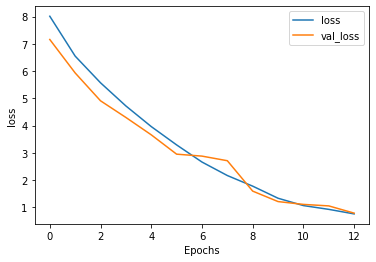

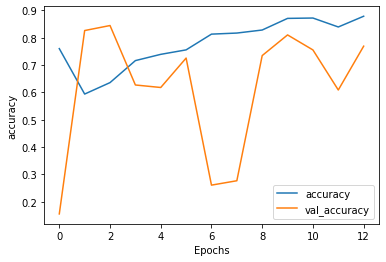

In [25]:
plot_graphs(classifier_history2, "loss")
plot_graphs(classifier_history2, "accuracy")

In [26]:
y_pred2 = classifier2.predict(X_test_seqs)
y_pred_classes2 = np.array([1 if pred > 0.5 else 0 for pred in y_pred2])

# classification report
acc2 = accuracy_score(y_true=y_test_labels, y_pred=y_pred_classes2)
print(acc2)

bal_acc2 = balanced_accuracy_score(y_true=y_test, y_pred=y_pred_classes2)
print(bal_acc2)

auc2 = roc_auc_score(y_true=y_test_labels, y_score=y_pred2)
print(auc2)

confusion_matrix_df2 = pd.DataFrame(
        confusion_matrix(y_true=y_test_labels, y_pred=y_pred_classes2, labels=[1, 0]),
        index=['True:pos', 'True:neg'], 
        columns=['Pred:pos', 'Pred:neg']
    )
print(confusion_matrix_df2)

print(classification_report(y_true=y_test_labels, y_pred=y_pred_classes2))

0.8443935926773455
0.5
0.6967758648174716
          Pred:pos  Pred:neg
True:pos         0        68
True:neg         0       369
              precision    recall  f1-score   support

           0       0.84      1.00      0.92       369
           1       0.00      0.00      0.00        68

    accuracy                           0.84       437
   macro avg       0.42      0.50      0.46       437
weighted avg       0.71      0.84      0.77       437



/home/dsv/zhwa9764/miniconda3/envs/py37-cuda11/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dsv/zhwa9764/miniconda3/envs/py37-cuda11/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dsv/zhwa9764/miniconda3/envs/py37-cuda11/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

### Add drop out layers

In [27]:
def DropoutClassifier(input_size, initial_bias):
    # Define the model structure - only LSTM layers
    inputs = keras.Input(input_size,)
    x = keras.layers.Embedding(input_dim=NUM_WORDS, output_dim=64, input_length=input_size)(inputs)
    x = keras.layers.LSTM(32, activation='tanh', kernel_regularizer=keras.regularizers.L1L2(l1=0.01, l2=0.01))(x)
    x = keras.layers.Dropout(0.6)(x)
    outputs = keras.layers.Dense(1, activation='sigmoid', 
                                 bias_initializer=keras.initializers.Constant(initial_bias))(x)

    classifier = keras.Model(inputs, outputs)
    
    optimizer = keras.optimizers.RMSprop(learning_rate=0.001)
    classifier.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return classifier

In [28]:
classifier3 = DropoutClassifier(input_size=MAX_LEN, initial_bias=initial_bias)

classifier3.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1000)]            0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 1000, 64)          192000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 204,449
Trainable params: 204,449
Non-trainable params: 0
_________________________________________________________________


In [29]:
early_stopping_loss = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode="min", restore_best_weights=True) # patient = 5 or 10 doesn't guarantee find an optimal


# Train the model
# reset_seeds()
classifier_history3 = classifier3.fit(X_train_seqs, 
          y_train_labels, 
          epochs=50,
          batch_size=128,
          shuffle=True, 
          verbose=True, 
          validation_data=(X_test_seqs, y_test_labels),
          callbacks=[early_stopping_loss],
          class_weight=class_weight)

Epoch 1/50
12/12 [==============================] - 2s 83ms/step - loss: 8.3866 - accuracy: 0.8248 - val_loss: 7.0534 - val_accuracy: 0.3913
Epoch 2/50
12/12 [==============================] - 1s 56ms/step - loss: 6.7668 - accuracy: 0.6478 - val_loss: 5.9006 - val_accuracy: 0.8421
Epoch 3/50
12/12 [==============================] - 1s 57ms/step - loss: 5.7733 - accuracy: 0.6766 - val_loss: 4.9090 - val_accuracy: 0.8444
Epoch 4/50
12/12 [==============================] - 1s 56ms/step - loss: 4.9356 - accuracy: 0.7471 - val_loss: 4.2925 - val_accuracy: 0.6453
Epoch 5/50
12/12 [==============================] - 1s 56ms/step - loss: 4.1301 - accuracy: 0.7346 - val_loss: 3.6337 - val_accuracy: 0.6064
Epoch 6/50
12/12 [==============================] - 1s 56ms/step - loss: 3.4554 - accuracy: 0.7340 - val_loss: 2.9175 - val_accuracy: 0.7666
Epoch 7/50
12/12 [==============================] - 1s 55ms/step - loss: 2.8327 - accuracy: 0.7705 - val_loss: 2.3582 - val_accuracy: 0.8055
Epoch 8/50
12

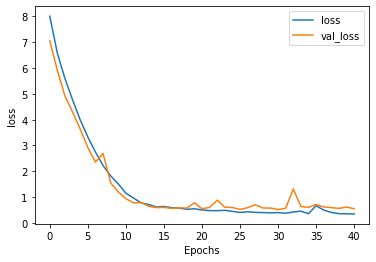

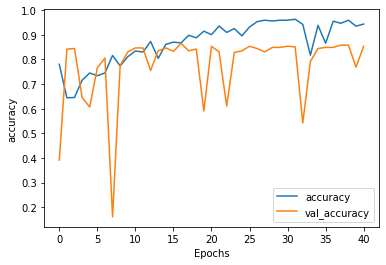

In [30]:
plot_graphs(classifier_history3, "loss")
plot_graphs(classifier_history3, "accuracy")

In [31]:
y_pred3 = classifier3.predict(X_test_seqs)
y_pred_classes3 = np.array([1 if pred > 0.5 else 0 for pred in y_pred3])

# classification report
acc3 = accuracy_score(y_true=y_test_labels, y_pred=y_pred_classes3)
print(acc3)

bal_acc3 = balanced_accuracy_score(y_true=y_test, y_pred=y_pred_classes3)
print(bal_acc3)

auc3 = roc_auc_score(y_true=y_test_labels, y_score=y_pred3)
print(auc3)

confusion_matrix_df3 = pd.DataFrame(
        confusion_matrix(y_true=y_test_labels, y_pred=y_pred_classes3, labels=[1, 0]),
        index=['True:pos', 'True:neg'], 
        columns=['Pred:pos', 'Pred:neg']
    )
print(confusion_matrix_df3)

print(classification_report(y_true=y_test_labels, y_pred=y_pred_classes3))

0.8535469107551488
0.6313765343535789
0.7050255061374143
          Pred:pos  Pred:neg
True:pos        21        47
True:neg        17       352
              precision    recall  f1-score   support

           0       0.88      0.95      0.92       369
           1       0.55      0.31      0.40        68

    accuracy                           0.85       437
   macro avg       0.72      0.63      0.66       437
weighted avg       0.83      0.85      0.84       437



### Add batch normalization


In [32]:
def BatchNormalizedClassifier(input_size, initial_bias):
    # Define the model structure - only LSTM layers
    inputs = keras.Input(input_size,)
    x = keras.layers.Embedding(input_dim=NUM_WORDS, output_dim=64, input_length=input_size)(inputs)
    x = keras.layers.LSTM(32, activation='tanh', kernel_regularizer=keras.regularizers.L1L2(l1=0.01, l2=0.01))(x)
    x = keras.layers.Dropout(0.6)(x)
    x = keras.layers.BatchNormalization()(x)
    outputs = keras.layers.Dense(1, activation='sigmoid', 
                                 bias_initializer=keras.initializers.Constant(initial_bias))(x)

    classifier = keras.Model(inputs, outputs)
    
    optimizer = keras.optimizers.RMSprop(learning_rate=0.001)
    classifier.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return classifier

In [33]:
classifier4 = BatchNormalizedClassifier(input_size=MAX_LEN, initial_bias=initial_bias)

classifier4.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1000)]            0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 1000, 64)          192000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 204,577
Trainable params: 204,513
Non-trainable params: 64
____________________________________________________

In [34]:
# Train the model
# reset_seeds()
classifier_history4 = classifier4.fit(X_train_seqs, 
          y_train_labels, 
          epochs=50,
          batch_size=128,
          shuffle=True, 
          verbose=True, 
          validation_data=(X_test_seqs, y_test_labels),
          callbacks=[early_stopping_loss],
          class_weight=class_weight)

Epoch 1/50
12/12 [==============================] - 2s 82ms/step - loss: 8.4780 - accuracy: 0.8013 - val_loss: 6.9725 - val_accuracy: 0.8444
Epoch 2/50
12/12 [==============================] - 1s 57ms/step - loss: 6.9758 - accuracy: 0.8423 - val_loss: 6.0012 - val_accuracy: 0.8444
Epoch 3/50
12/12 [==============================] - 1s 55ms/step - loss: 5.9169 - accuracy: 0.8649 - val_loss: 5.1886 - val_accuracy: 0.8444
Epoch 4/50
12/12 [==============================] - 1s 56ms/step - loss: 5.0136 - accuracy: 0.8610 - val_loss: 4.4756 - val_accuracy: 0.8444
Epoch 5/50
12/12 [==============================] - 1s 57ms/step - loss: 4.2047 - accuracy: 0.8558 - val_loss: 3.8261 - val_accuracy: 0.8444
Epoch 6/50
12/12 [==============================] - 1s 56ms/step - loss: 3.5613 - accuracy: 0.8332 - val_loss: 3.2394 - val_accuracy: 0.8444
Epoch 7/50
12/12 [==============================] - 1s 56ms/step - loss: 2.9948 - accuracy: 0.8611 - val_loss: 2.7365 - val_accuracy: 0.8444
Epoch 8/50
12

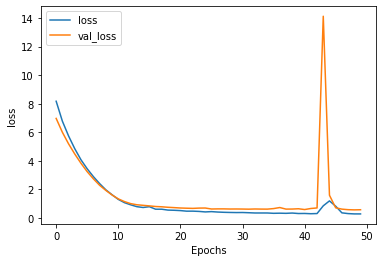

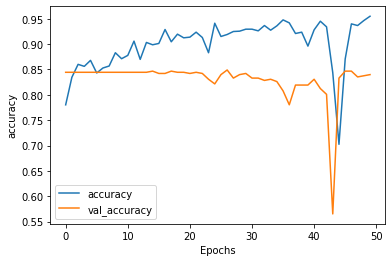

In [35]:
plot_graphs(classifier_history4, "loss")
plot_graphs(classifier_history4, "accuracy")

In [36]:
y_pred4 = classifier4.predict(X_test_seqs)
y_pred_classes4 = np.array([1 if pred > 0.5 else 0 for pred in y_pred4])

# classification report
acc4 = accuracy_score(y_true=y_test_labels, y_pred=y_pred_classes4)
print(acc4)

bal_acc4 = balanced_accuracy_score(y_true=y_test_labels, y_pred=y_pred_classes4)
print(bal_acc4)

auc4 = roc_auc_score(y_true=y_test_labels, y_score=y_pred4)
print(auc4)

confusion_matrix_df4 = pd.DataFrame(
        confusion_matrix(y_true=y_test_labels, y_pred=y_pred_classes4, labels=[1, 0]),
        index=['True:pos', 'True:neg'], 
        columns=['Pred:pos', 'Pred:neg']
    )
print(confusion_matrix_df4)

print(classification_report(y_true=y_test_labels, y_pred=y_pred_classes4))

0.8398169336384439
0.5332775386577395
0.5197672564960943
          Pred:pos  Pred:neg
True:pos         6        62
True:neg         8       361
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       369
           1       0.43      0.09      0.15        68

    accuracy                           0.84       437
   macro avg       0.64      0.53      0.53       437
weighted avg       0.79      0.84      0.79       437



### stack two LSTM layers

In [37]:
# Stack two or more LSTM layers
def StackedClassifier(input_size):
    # Define the model structure - only LSTM layers
    inputs = keras.Input(input_size,)
    x = keras.layers.Embedding(input_dim=NUM_WORDS, output_dim=64, input_length=input_size)(inputs)
    x = keras.layers.LSTM(32, activation='tanh', return_sequences=True)(x)
    x = keras.layers.Dropout(0.6)(x)
#     x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LSTM(16, activation='tanh', return_sequences=False)(x)
    x = keras.layers.Dropout(0.6)(x)
#     x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(16, activation='relu')(x)
    outputs = keras.layers.Dense(1, activation='sigmoid')(x)

    classifier = keras.Model(inputs, outputs)

    optimizer = keras.optimizers.RMSprop(learning_rate=0.001)
    classifier.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return classifier

In [38]:
classifier5 = StackedClassifier(input_size=MAX_LEN)

classifier5.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 1000)]            0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 1000, 64)          192000    
_________________________________________________________________
lstm_4 (LSTM)                (None, 1000, 32)          12416     
_________________________________________________________________
dropout_2 (Dropout)          (None, 1000, 32)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272 

In [39]:
# Train the model
# reset_seeds()
classifier_history5 = classifier5.fit(X_train_seqs, 
          y_train_labels, 
          epochs=50,
          batch_size=128,
          shuffle=True, 
          verbose=True, 
          validation_data=(X_test_seqs, y_test_labels),
          callbacks=[early_stopping_accuracy])


Epoch 1/50
12/12 [==============================] - 4s 127ms/step - loss: 0.6476 - accuracy: 0.7459 - val_loss: 0.4334 - val_accuracy: 0.8444
Epoch 2/50
12/12 [==============================] - 1s 88ms/step - loss: 0.4625 - accuracy: 0.8329 - val_loss: 0.4075 - val_accuracy: 0.8444
Epoch 3/50
12/12 [==============================] - 1s 88ms/step - loss: 0.4285 - accuracy: 0.8222 - val_loss: 0.3874 - val_accuracy: 0.8444
Epoch 4/50
12/12 [==============================] - 1s 88ms/step - loss: 0.3672 - accuracy: 0.8268 - val_loss: 0.3871 - val_accuracy: 0.8444
Epoch 5/50
12/12 [==============================] - 1s 89ms/step - loss: 0.3249 - accuracy: 0.8435 - val_loss: 0.3869 - val_accuracy: 0.8535
Epoch 6/50
12/12 [==============================] - 1s 88ms/step - loss: 0.3140 - accuracy: 0.8606 - val_loss: 0.4000 - val_accuracy: 0.8673
Epoch 7/50
12/12 [==============================] - 1s 89ms/step - loss: 0.2947 - accuracy: 0.9082 - val_loss: 0.4617 - val_accuracy: 0.8513
Epoch 8/50
1

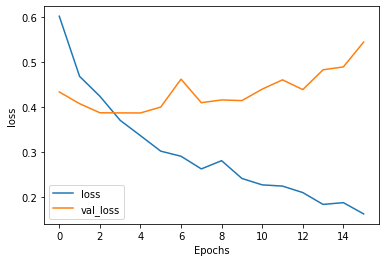

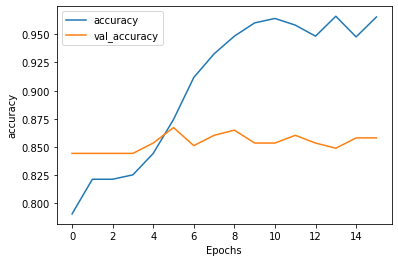

In [40]:
plot_graphs(classifier_history5, "loss")
plot_graphs(classifier_history5, "accuracy")

In [41]:
y_pred5 = classifier5.predict(X_test_seqs)
y_pred_classes5 = np.array([1 if pred > 0.5 else 0 for pred in y_pred5])

acc5 = accuracy_score(y_true=y_test_labels, y_pred=y_pred_classes5)
print(acc5)

bal_acc5 = balanced_accuracy_score(y_true=y_test_labels, y_pred=y_pred_classes5)
print(bal_acc5)

auc5 = roc_auc_score(y_true=y_test_labels, y_score=y_pred5)
print(auc5)

confusion_matrix_df5 = pd.DataFrame(
        confusion_matrix(y_true=y_test_labels, y_pred=y_pred_classes5, labels=[1, 0]),
        index=['True:pos', 'True:neg'], 
        columns=['Pred:pos', 'Pred:neg']
    )
print(confusion_matrix_df5)

print(classification_report(y_true=y_test_labels, y_pred=y_pred_classes5))

0.8672768878718535
0.5915231946437112
0.7334409373505499
          Pred:pos  Pred:neg
True:pos        13        55
True:neg         3       366
              precision    recall  f1-score   support

           0       0.87      0.99      0.93       369
           1       0.81      0.19      0.31        68

    accuracy                           0.87       437
   macro avg       0.84      0.59      0.62       437
weighted avg       0.86      0.87      0.83       437



### Grid search (TODO)


In [44]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [61]:
# Stack two or more LSTM layers
def GridsearchClassifier(dropout, l1, l2, input_size=1000):
    # Define the model structure - only LSTM layers
    inputs = keras.Input(input_size,)
    x = keras.layers.Embedding(input_dim=NUM_WORDS, output_dim=64, input_length=input_size)(inputs)
    x = keras.layers.LSTM(32, activation='tanh', return_sequences=True, kernel_regularizer=keras.regularizers.L1L2(l1=l1, l2=l2))(x)
    x = keras.layers.Dropout(dropout)(x)
#     x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LSTM(16, activation='tanh', return_sequences=False)(x)
    x = keras.layers.Dropout(dropout)(x)
#     x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(16, activation='relu')(x)
    outputs = keras.layers.Dense(1, activation='sigmoid')(x)

    classifier = keras.Model(inputs, outputs)

    optimizer = keras.optimizers.RMSprop(learning_rate=0.001)
    classifier.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return classifier

In [62]:
keras_estimator = KerasClassifier(build_fn=GridsearchClassifier, verbose=1)
estimator = Pipeline([("kc", keras_estimator)])

# define the grid search parameters
param_grid = {
#     'kc__dense_nparams': [32],
    'kc__batch_size':[2, 16, 32, 64, 512],
    'kc__l1':[0.01, 0.02, 0.03],
    'kc__l2':[0.01,0.02, 0.02],
    'kc__dropout': [0.5, 0.4, 0.3, 0.2, 0.1, 0],
    #'kc__dropout': [0.5],
}

In [54]:
X_gs_concate = np.concatenate((X_train_seqs, X_val_seqs), axis=0)
y_gs_concate = np.concatenate((y_train_labels, y_val_labels), axis=0)

In [52]:
# The indices which have the value -1 will be kept in train
train_indices = np.full((X_test_seqs.shape[0],), -1, dtype=int)
# The indices which have zero or positive values, will be kept in val
val_indices = np.full((X_val_seqs.shape[0],), 0, dtype=int)

val_fold = np.append(train_indices, val_indices)
print(val_fold)

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1

In [65]:
from sklearn.model_selection import PredefinedSplit
ps = PredefinedSplit(val_fold)

scoring = {'AUC': 'roc_auc'}

grid = GridSearchCV(estimator=estimator,  
                    n_jobs=-1, 
                    verbose=1,
                    return_train_score=True,
                    scoring=scoring,
                    cv=ps,  #StratifiedKFold(n_splits=kfold_splits, shuffle=True)
                    param_grid=param_grid,
                    refit = 'AUC')

In [69]:
grid_result = grid.fit(X_gs_concate, y_gs_concate) #callbacks=[tbCallBack]

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 1 folds for each of 270 candidates, totalling 270 fits
874/874 [==============================] - 43s 47ms/step - loss: 2.1852 - accuracy: 0.7971
Best: nan using {'kc__batch_size': 2, 'kc__dropout': 0.5, 'kc__l1': 0.01, 'kc__l2': 0.01}
